# 2-dimensional growing self-avoiding walks
Author: Christophe Laforge

### Objectives
The objectives of this code is to generate a walk on a square lattice with does not intersect.<br>
A brute force approach would be to move randomly on the square lattice and to test if the walk has alreaday passed throuugh the tentative new position. This is however inefficient for the reason that numerous attempt will failed because of bloccage. A bloccage is a situation where there is no next possible step to be taken by the random walk. It is trapped.<br>
To avoid bloccage, we need to design a smarter algorithm that identify the situations that could lead to a bloccage and take the appropriate action to avoid them. This seems sensible but our implementation has an undesirable effect. Indeed, we have ignored the possible cases where the walk would take an action that could lead to a bloccage if the desired length of the walk would be big enough but could accomodate the input desired length. Said differently, our algorithm will avoid entering in a trap that would allow it to growth sufficiently to meet the desired total length. <br>
The undesirable consequences of this implementation is therefore that we have a biais sample of the set of all possible SAW of a given length.

### Conventions
We abbreviate self-avoiding walks with SAW. <br>
All SAW starts at (0,0). <br> 
The first move of all SAW is to the direction of increasing X. <br>
The possible actions are:
0. right or increasing X
1. up or increasing Y
2. left or decreasing X
3. down or decreasing Y

### User-defined functions
1. SpecialCaseDetection: detect the situations for which some special cases that will influence the next action.
2. AddStep: increment the SAW based on the provided action
3. OneStepWithoutReverse: increment the SAW randomly but without going back to the last step
4. WhichAction: helper function that give the action provided the move
5. PossibleActionWithoutReverse: helper function that return the set of actions but the reverse of the last action
6. WhichActionBasedOnStep: helper function that identifies the action that bring the start point to the end point

In [29]:
def SpecialCaseDetection(Walk):
    
    ''' This function detects three types of special cases in the construction of a SAW
    0. Collision: when the position (X,Y) are already part of the Walk.
    1. Contact: when the position (X,Y) is in contact with at least one step of the SAW
    2. Corner: when the position (X,Y) is in contact with a step with one corner
    Priority is given to collision, than to contact, than to corner.
    ie if there is a collision and a contact, the function returns the details of the collision, 
    ignoring the contact
    If several contacts take place, the function returns the first one in the SAW
    The first output is 0,1,2 for the three cases mentioned above.
    The second ouput is the step for the collision, contact or corner.
    In absence of collision, contact or corner situation, the function return the length of the SAW.
    It is important to note that the algorithm will not check all the step in the SAW but will jump several steps
    whenever it is clear that there is nothing relevant in the jumped part of the SAW.
    '''
    
    WalkLength = len(Walk)         #length of the walk, ie nbr of steps
    CurrentStep = 0                #we start at the beginning of the walk
    ReachedEnd = False             #and we assume we have not yet reach the end of the walk
    
    #Outputs
    OutputDistance = WalkLength    #The first output is given the length of the walk by default
    OutputStep = WalkLength        #The second output is given the length of the walk by default
    
    #Memory: if a contact or a corner is detected, we still need to continue searching for a potential collision
    #we therefore need to keep the memory of the first corner and the first contact
    FirstCorner = WalkLength
    FirstContact = WalkLength
    SecondContact = WalkLength
    
    #X,Y is the coordinate of the last step taken.
    #Given the SAW is built step by step, the special cases need to be searched for this last step
    X = Walk[-1][0]
    Y = Walk[-1][1]
    #print(X,Y)
    
    #We loop until the end of the SAW is reached or a collision takes place
    while not ReachedEnd:

        #We compute two different distances between the current step and the last step
        #The squared euclidian distance (L2) and the Manhattan distance (L1)
        #The Manhattan distance will be used to define the number of step we can safely skip
        #The euclidien distance will be used to test for collision, contact or corner situations
        DistanceL2 = (Walk[CurrentStep][0]-X)**2+(Walk[CurrentStep][1]-Y)**2
        DistanceL1 = abs(Walk[CurrentStep][0]-X)+abs(Walk[CurrentStep][1]-Y)

        #We do not need to check every single steps in the SAW. 
        #Indeed, if the Manhattan distance gives the minimum number of steps needed to connect the current step
        #and the last step of the walk. We can therefore safely jump a number of steps corresponding to the 
        #Manhattan distance. We will however remove 2 because the corner case we are trying to detect could take
        #place 2 steps before.
        #Of course, we want to move at least 1 step, thus the max function
        #For long SAW, this increment is a major efficient gain in the running of the algorithm
        StepIncrement = max(DistanceL1 - 2,1)
                
        #Collision: if the euclidien or the Manhattan distance is null, then there is a collision 
        #The function returns 0 and the location of the collision in the walk (stop searching)
        if DistanceL2 == 0: return -1,DistanceL2

        #Contact: A contact happens when the euclidien or the Manhattan distance is 1.
        #Assuming no collision with a later step in the SAW, 
        #the function returns 1 and the location of the contact.
        #the loop continues to garantee there is no collision later on in the SAW
        if DistanceL2 == 1 :
            #The function only returns the first contact
            #FirstContact is initially set to the length of the SAW.
            #It will be set to the current step at the first contact.
            #If there is a second contact, the output information will not be modified thanks to the condition:
            if CurrentStep < FirstContact:
                FirstContact = CurrentStep   #store the location of the first contact
                if FirstContact==FirstCorner+1:
                    FirstCorner = WalkLength
            
        #Corner: A corner happens when the euclidien distance is 2.
        #The Manhattan distance in this situation is also 2 but there are other cases where it takes the value
        #of 2 without being a corner.
        #we need to exclude the situations where a contact has already been detected. This is done by checking
        #that the OutputDistance is strictly greated than 1. Indeed, if a contact would have been detected already
        #the OuputDistance would have been assigned a value of 1.
        #the function returns 2 and the location of the corner.
        #the loop continues to garantee there is no collision or contact later on in the SAW
        if DistanceL2 == 2 and (CurrentStep-FirstContact!=1):
            #The function only returns the first corner
            #FirstCorner is initially set to the length of the SAW.
            #It will be set to the current step at the first corner.
            #If there is a second corner, the output information will not be modified thanks to the condition:
            if CurrentStep < FirstCorner:
                FirstCorner = CurrentStep       #store the location of the first contact
            
        #Give the StepIncrement has been defined for all the special cases, we can jump to the relevant next
        #step in the SAW
        CurrentStep += StepIncrement   
        #print("CurrentStep: ",CurrentStep)
                
        #Given the new CurrentStep, we need to check if we have reached the end of the SAW
        #The WalkLength - 3 can be understood with the following argument:
        # -2 because the interaction of the last step with the last two steps is irrelevant.
        # -1 because the CurrentStep is defined as starting from 0, where WalkLength is defined as starting from 1
        if CurrentStep >= (WalkLength-3):
            ReachedEnd = True

    #there is a third tricky case: when there is a corner and a contact
    #The exit strategy in those circonstance is simply to get away from the contact
    #The corner is always before the contact
    #The case when the contact is before the corner
        
    return FirstContact,FirstCorner

In [30]:
SAW = [(0, 0), (1, 0), (2, 0), (3, 0), (3, 1), (3, 2), (2, 2), (2, 3), (3, 3), (4, 3),(4,2)]  #expect (5,11)
print(SpecialCaseDetection(SAW))

(5, 11)


In [126]:
from random import randint, seed

def AddStep(Walk,Action):
    
    '''This helper function has the mandate to add a step to the walk given an action'''
    
    #The coordinate of the last position of the walk
    CurrentX = Walk[-1][0]
    CurrentY = Walk[-1][1]
    
    #We defined the coordinate of the new step based on the action
    if Action == 0: #right or increasing X
        NewX = CurrentX + 1
        NewY = CurrentY
    if Action == 1: #up or increasing Y
        NewX = CurrentX
        NewY = CurrentY + 1
    if Action == 2: #left or decreasing X
        NewX = CurrentX - 1
        NewY = CurrentY
    if Action == 3: #down or decreasing Y
        NewX = CurrentX
        NewY = CurrentY - 1
        
    #and we simply append this new step to the SAW
    Walk.append((NewX,NewY))
    return _

def OneStepWithoutReverse(Walk,LastAction):
    
    '''This function return a random action selected from the three actions possible given the last action'''
    
    #Acquire all the possible actions except going back to where you come from (LastAction)
    PossibleNextAction= PossibleActionWithoutReverse(LastAction)
    
    #and select the next action randomly
    #the len function start counting at 1, but the action space is defined from 0. This explains the -2
    NextAction = PossibleNextAction[randint(0,len(PossibleNextAction))-2]

    #Given the action, we can add a step to the SAW
    AddStep(Walk,NextAction)
  
    return NextAction

def PossibleActionWithoutReverse(LastAction):

    #Let us defined the action space and the opposite actions for each action in the action space
    AllActions = [0,1,2,3]
    OppositeActions = [2,3,0,1]  #I could have written this nicely as AllAction + 2 modulo 4.

    #The set of all possible action is set first to the action space
    #from which we remove the action corresponding to the opposite of the last action
    PossibleActions= AllActions
    PossibleActions.remove(OppositeActions[LastAction])
    
    return PossibleActions

def WhichAction(deltaX,deltaY):
    
    '''Helper function that return the action number based on the move'''
    
    #if the move is not in the action space, then the function return -1
    output = -1
    
    if deltaX == 1 and deltaY == 0: output = 0  #right or increasing X
    if deltaX == 0 and deltaY == 1: output = 1  #up or increasing Y
    if deltaX == -1 and deltaY == 0: output = 2 #left or decreasing X
    if deltaX == 0 and deltaY == -1: output = 3 #down or decreasing Y
        
    return output

def WhichActionBasedOnStep(StartPoint,EndPoint):
    
    '''Helper function to identify the action that would lead the start point to the end point'''
    
    StartX = StartPoint[0]
    StartY = StartPoint[1]
    EndX = EndPoint[0]
    EndY = EndPoint[1]
    MoveX = EndX - StartX
    MoveY = EndY - StartY
    
    return WhichAction(MoveX,MoveY)

def RemoveFlowAction(Walk,PossibleActions,keyStep):

    DidItWentAroundOrigin = WentAroundOrigin(Walk,keyStep)
    #print("Around zero: ",DidItWentAroundOrigin)
    
    if DidItWentAroundOrigin:
        #Identify the action that would make going in the same direction than the flow before and after the contact
        FirstFlowAction = WhichActionBasedOnStep(Walk[keyStep],Walk[keyStep-1])
        SecondFlowAction = WhichActionBasedOnStep(Walk[keyStep+1],Walk[keyStep])
    else:
        #Identify the action that would make going in the same direction than the flow before and after the contact
        FirstFlowAction = WhichActionBasedOnStep(Walk[keyStep-1],Walk[keyStep])
        SecondFlowAction = WhichActionBasedOnStep(Walk[keyStep],Walk[keyStep+1])
        
    #and remove them if it is still in the possible list of next action
    if FirstFlowAction in PossibleActions:
        PossibleActions.remove(FirstFlowAction)
    if SecondFlowAction in PossibleActions:
        PossibleActions.remove(SecondFlowAction)

    return PossibleActions

def WentAroundOrigin(Walk,StartStep):
    '''Helper function that return true if the walk from Start step to the end
    went around the origin of the walk (0,0)'''
    
    AroundOrigin = False
    QuadrantChange = 0
    
    for step in range(StartStep,len(Walk)-2):
        if(Walk[step][0]==0 and Walk[step+1][0]<0):
            if(Walk[step][1]>0): QuadrantChange -= 1
            if(Walk[step][1]<0): QuadrantChange += 1
        if(Walk[step][0]==0 and Walk[step+1][0]>0):
            if(Walk[step][1]>0): QuadrantChange += 1
            if(Walk[step][1]<0): QuadrantChange -= 1
        if(Walk[step][1]==0 and Walk[step+1][1]<0):
            if(Walk[step][0]>0): QuadrantChange += 1
            if(Walk[step][0]<0): QuadrantChange -= 1
        if(Walk[step][1]==0 and Walk[step+1][1]>0):
            if(Walk[step][0]>0): QuadrantChange -= 1
            if(Walk[step][0]<0): QuadrantChange += 1

    #print("Quadrant: ",QuadrantChange)

    if QuadrantChange >= 4:
        AroundOrigin = True
        print("Quadrant: ",QuadrantChange)
    if QuadrantChange <= -4:
        AroundOrigin = True      
        print("Quadrant: ",QuadrantChange)
    
    return AroundOrigin

def OneStepWithContact(Walk,LastAction,ContactStep):
        
    #Acquire all the possible actions except going back to where you come from (LastAction)
    PossibleNextAction= PossibleActionWithoutReverse(LastAction)
    #print("Possible Actions: ",PossibleNextAction)
    
    #If there is a contact, it means that a collision is possible
    #we need first to identify the action that would lead to the collision
    CollisionAction = WhichActionBasedOnStep(Walk[-1],Walk[ContactStep])

    #and remove it from the possible action
    if CollisionAction in PossibleNextAction:
        PossibleNextAction.remove(CollisionAction)
    #print("Possible Actions: ",PossibleNextAction)
    
    #Identify and remove the actions in the same direction than the flow before and after the contact
    PossibleNextAction = RemoveFlowAction(Walk,PossibleNextAction,ContactStep)
    #print("Possible Actions: ",PossibleNextAction)
    
    #and select the next action randomly
    NextAction = PossibleNextAction[randint(0,len(PossibleNextAction)-1)]

    AddStep(Walk,NextAction)
    
    return NextAction

def OneStepWithCorner(Walk,LastAction,CornerStep):
    
    #Acquire all the possible actions except going back to where you come from (LastAction)
    PossibleNextAction= PossibleActionWithoutReverse(LastAction)
    
    #Identify and remove the actions in the same direction than the flow before and after the contact
    PossibleNextAction = RemoveFlowAction(Walk,PossibleNextAction,CornerStep)

    #and select the next action randomly
    NextAction = PossibleNextAction[randint(0,len(PossibleNextAction)-1)]

    AddStep(Walk,NextAction)

    return NextAction

def OneStepWithContactAndCorner(Walk,LastAction,ContactStep,CornerStep):

    
    #Acquire all the possible actions except going back to where you come from (LastAction)
    PossibleNextAction= PossibleActionWithoutReverse(LastAction)
    
    if ContactStep == 25 and CornerStep == 28:
        print("Possible Actions: ", PossibleNextAction)

    #If there is a contact, it means that a collision is possible
    #we need first to identify the action that would lead to the collision
    CollisionAction = WhichActionBasedOnStep(Walk[-1],Walk[ContactStep])

    #and remove it from the possible action
    if CollisionAction in PossibleNextAction:
        PossibleNextAction.remove(CollisionAction)

    if ContactStep == 25 and CornerStep == 28:
        print("Possible Actions: ", PossibleNextAction)

    #Identify and remove the actions in the same direction than the flow before and after the contact
    #PossibleNextAction = RemoveFlowAction(Walk,PossibleNextAction,ContactStep)
    
    #Identify and remove the actions in the same direction than the flow before and after the contact
    PossibleNextAction = RemoveFlowAction(Walk,PossibleNextAction,CornerStep)

    if ContactStep == 25 and CornerStep == 28:
        print("Possible Actions: ", PossibleNextAction)

    #and select the next action randomly
    NextAction = PossibleNextAction[randint(0,len(PossibleNextAction)-1)]

    AddStep(Walk,NextAction)
    
    return NextAction

Corner: 4
Position:  (-14, 3)
Position:  (-14, 4)
Position:  (-15, 4)
Position:  (-16, 4)
Position:  (-17, 4)
Position:  (-17, 3)
Position:  (-18, 3)
Position:  (-19, 3)
Position:  (-19, 2)
Position:  (-18, 2)
Corner: 35
Position:  (-17, 2)
Corner: 36
Position:  (-16, 2)
Contact: 37
Position:  (-16, 3)
Corner: 38
Position:  (-15, 3)
Contact and Corner: 25 28
Possible Actions:  [0, 1, 3]
Possible Actions:  [1, 3]
Possible Actions:  [1, 3]
Position:  (-15, 4)
A collision has happened. Something is wrong in the existing code!
(-15, 4)
Contact and Corner: -1 0
Position:  (-16, 4)
A collision has happened. Something is wrong in the existing code!
(-16, 4)
Contact and Corner: -1 0
Position:  (-16, 3)
A collision has happened. Something is wrong in the existing code!
(-16, 3)
Contact and Corner: -1 0
Position:  (-17, 3)
A collision has happened. Something is wrong in the existing code!
(-17, 3)
Contact and Corner: -1 0
Position:  (-17, 4)


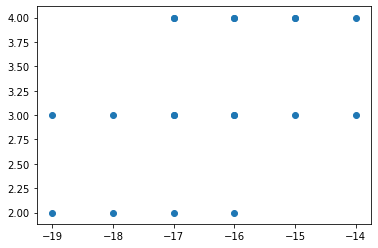

In [127]:
import numpy as np
import matplotlib.pyplot as plt
seed(1)

# A key input is the desired length of the SAW
TargetLength = 40

# As stated in the convention, the starting point is (0,0).
# This cannot be modified.
SAW = [(0,0)]
SAWL = 1

# As stated in the conventions, the first move is to the right (increasing x)
SAW.append((1,0))
LastAction = 0
SAWL += 1

#The next two steps can be performed savely as there is no risk of collision
#The only unauthorised move is to reverse the last action taken.
LastAction = OneStepWithoutReverse(SAW,LastAction)
SAWL += 1
#print(SAW[-1])

LastAction = OneStepWithoutReverse(SAW,LastAction)
SAWL += 1
#print(SAW[-1])

for _ in range(TargetLength):

    #Before adding any step to the walk, we need to check the existence of special scenarios:
    # 1. Is there a collision (which would imply that something went wrong in the previous decision)
    # 2. Is the last step entering in contact with the walk
    # 3. Is the last step touching the corner of the walk
    # In both 2 and 3, the next action to be taken is restricted such that the walk does not get trapped
    
    FirstContact, FirstCorner = SpecialCaseDetection(SAW)
    #print("Special case: ", FirstContact, FirstCorner)
    
    if FirstContact == -1:
        # there is a collision
        print("A collision has happened. Something is wrong in the existing code!")
        print(SAW[-1])

    if FirstContact == SAWL and FirstCorner == SAWL:    
        #The SpecialCaseDetection returns the length of the walk if there is no collision, contact or corner.
        #In that case, the next step can be safely taken in any direction but the reverse of the last action.
        LastAction = OneStepWithoutReverse(SAW,LastAction)

    if FirstContact != SAWL and FirstCorner != SAWL:
        #This is the new case with a corner and a contact
        print("Contact and Corner:",FirstContact,FirstCorner)
        LastAction = OneStepWithContactAndCorner(SAW,LastAction,FirstContact,FirstCorner)
        
    if FirstContact != SAWL and FirstCorner == SAWL:
        #contact: the last step entered in contact with the walk.
        #the SpecialCaseDetection returns the location of the first contact if there was to be more than one.
        #the action to be selected is given by a dedicated function
        print("Corner:",FirstCorner)
        LastAction = OneStepWithContact(SAW,LastAction,FirstContact)

    if FirstContact == SAWL and FirstCorner != SAWL:
        #corner: the last step touches a vertex of the walk
        #the SpecialCaseDetection returns the location of the first vertex being touched
        #the action to be selected is given by a dedicated function
        print("Contact:",FirstContact)
        LastAction = OneStepWithCorner(SAW,LastAction,FirstCorner)
    SAWL += 1
    
    if SAWL > 25:
        print("Position: ",SAW[-1])

x = [element[0] for element in SAW[25:]]
y = [element[1] for element in SAW[25:]]
plt.scatter(x,y)


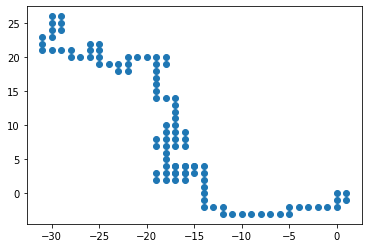

In [99]:
import numpy as np
import matplotlib.pyplot as plt

plt.scatter(x,y)

In [98]:
x = [element[0] for element in SAW]
y= [element[1] for element in SAW]